### download bert score package

In [ ]:
!pip install bert_score

### download spacy for German and English language

In [ ]:
%%bash
python -m spacy download en
python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


### download torchtext

In [ ]:
!pip install torchtext

### Import the required files

In [ ]:
import random
from typing import Tuple

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List
from bert_score import score

import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import math
import time



# 4 - Packed Padded Sequences, Masking, Inference and BLEU

## Introduction

In this notebook we will be adding a few improvements - packed padded sequences and masking - to the model from the previous notebook. Packed padded sequences are used to tell our RNN to skip over padding tokens in our encoder. Masking explicitly forces the model to ignore certain values, such as attention over padded elements. Both of these techniques are commonly used in NLP. 

We will also look at how to use our model for inference, by giving it a sentence, seeing what it translates it as and seeing where exactly it pays attention to when translating each word.

Finally, we'll use the BLEU metric to measure the quality of our translations.

## Preparing Data



Next, we'll set the random seed for reproducability.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

As before, we'll import spaCy and define the German and English tokenizers.

In [ ]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

#### set constant strings for source and target language

In [ ]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

#### Get function pointers for source and target language

In [ ]:
# Create source and target language tokenizer. Make sure to install the dependencies.

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en')

#### Helper function to yield tokens

In [ ]:
# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

#### Define special symbols

In [ ]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

#### Create vocabulary transforms for source and target language

*  create a function pointer to build the vocabulary for source and target language.

In [ ]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  # Training data Iterator 
  train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  # Create torchtext's Vocab object 
  vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 597kB/s]


In [ ]:
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

### collate function

*  define a Sequential transform closure function , which takes a list of function pointers of transform function
   
   * the transform function transforms the input text and return the transformed text.

*  define a tensor transform function , which takes the token id of the text

   *  inserts a <bos> and ,eos> token at the begining and end of the token ids list

   *  return a tensor object

*  Create text transform handle for source and target language

   *  The text transform has a sequential transform handle which applies

      *  token tranform on input sentence

      *  then vocab transform 

      *  then tensor transform

*  define a collate function to apply the transform on each batch for source and target language

   *  apply text transform on input text and save this in a list

   *  pad the source and target sentences 

In [ ]:
######################################################################
# Collation
# ---------
#   
# As seen in the ``Data Sourcing and Processing`` section, our data iterator yields a pair of raw strings. 
# We need to convert these string pairs into the batched tensors that can be processed by our ``Seq2Seq`` network 
# defined previously. Below we define our collate function that convert batch of raw strings into batch tensors that
# can be fed directly into our model.   
#


from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors , with padding
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

Since the source sentences are padded , so there is no issue in using packed padded sequences.The length of source sentence is a 1d tensor of source sentences length.

## Building the Model

### Encoder

Next up, we define the encoder.

The changes here all within the `forward` method. It now accepts the lengths of the source sentences as well as the sentences themselves. 

After the source sentence (padded automatically within the iterator) has been embedded, we can then use `pack_padded_sequence` on it with the lengths of the sentences. Note that the tensor containing the lengths of the sequences must be a CPU tensor as of the latest version of PyTorch, which we explicitly do so with `to('cpu')`. `packed_embedded` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packed_outputs`, a packed tensor containing all of the hidden states from the sequence, and `hidden` which is simply the final hidden state from our sequence. `hidden` is a standard tensor and not packed in any way.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the `outputs` and the lengths of each, which we don't need. 

The first dimension of `outputs` is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

The output of the linear layer is passed through tanh activation to set the range within -1 to 1

### encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        #self.fc = nn.Linear(enc_hid_dim , dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        src_len = torch.ones(src.shape[1] , dtype=torch.int64)*src.shape[0]
        #print(src.shape , src_len)
        embedded = self.dropout(self.embedding(src))
        #packed_embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
        
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        #hidden = torch.tanh(self.fc(hidden))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

The attention module is where we calculate the attention values over the source sentence. 

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using *masking*, we can force the attention to only be over non-padding elements.

The `forward` method now takes a `mask` input. This is a **[batch size, source sentence length]** tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: ["hello", "how", "are", "you", "?", `<pad>`, `<pad>`], then the mask would be [1, 1, 1, 1, 1, 0, 0].

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        #print('attn',hidden.shape)
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #print('after attn',hidden.shape)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Decoder

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference. 

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the `forward` method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each time-step is stored in the `attentions` 

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            #print(src.shape , trg.shape, input.shape, hidden.shape, encoder_outputs.shape, mask.shape )
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

## Training the Seq2Seq Model

Next up, initializing the model and placing it on the GPU.

### Initialize parameters

In [ ]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TGT_LANGUAGE])
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, PAD_IDX, device).to(device)

Then, we initialize the model parameters.

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(19206, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(10840, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=10840, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

We'll print out the number of trainable parameters in the model, noticing that it has the exact same amount of parameters as the model without these improvements.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 33,561,176 trainable parameters


Then we define our optimizer and criterion. 

The `ignore_index` for the criterion needs to be the index of the pad token for the target language, not the source language.

In [ ]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
optimizer = optim.Adam(model.parameters())

### Next, we'll define our training and evaluation loops.

As we are using padded source field, src_len is source tensor dim 0

Our model also returns the attention vectors over the batch of source source sentences for each decoding time-step. We won't use these during the training/evaluation, but we will later for inference.

In [ ]:
from torch.utils.data import DataLoader


def train(model, optimizer, criterion, clip):

    model.train()

    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    epoch_loss = 0
    
    for src, trg in train_dataloader:

        src = src.to(device)
        trg = trg.to(device)
        src_len = src.shape[0]
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(train_dataloader) 

In [ ]:
def evaluate(model, criterion , evaldata = 'valid'):


    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():

        val_iter = Multi30k(split= evaldata , language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
        val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

        for src, trg in val_dataloader:
            src = src.to(device)
            trg = trg.to(device)
            src_len = src.shape[0]

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(val_dataloader)

Then, we'll define a useful function for timing how long epochs take.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

The penultimate step is to train our model. Notice how it takes almost half the time as our model without the improvements added in this notebook.

### run the model

In [ ]:
N_EPOCHS = 10 # 20
CLIP = 1

trainLossList = []
valLossList = []

trainAccyList = []
valAccyList = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'packedmulti30k-model.pt')

    trainLossList.append(round(train_loss,2))
    valLossList.append(round(valid_loss,2))

    trainAccyList.append(round(math.exp(train_loss),2))
    valAccyList.append(round(math.exp(valid_loss),2))
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 90.7kB/s]


Epoch: 01 | Time: 0m 59s
	Train Loss: 5.149 | Train PPL: 172.290
	 Val. Loss: 4.821 |  Val. PPL: 124.130
Epoch: 02 | Time: 0m 56s
	Train Loss: 3.964 | Train PPL:  52.678
	 Val. Loss: 4.223 |  Val. PPL:  68.236
Epoch: 03 | Time: 0m 56s
	Train Loss: 3.325 | Train PPL:  27.798
	 Val. Loss: 3.985 |  Val. PPL:  53.780
Epoch: 04 | Time: 0m 56s
	Train Loss: 2.835 | Train PPL:  17.029
	 Val. Loss: 3.749 |  Val. PPL:  42.496
Epoch: 05 | Time: 0m 57s
	Train Loss: 2.465 | Train PPL:  11.762
	 Val. Loss: 3.648 |  Val. PPL:  38.380
Epoch: 06 | Time: 0m 56s
	Train Loss: 2.154 | Train PPL:   8.618
	 Val. Loss: 3.676 |  Val. PPL:  39.483
Epoch: 07 | Time: 0m 56s
	Train Loss: 1.935 | Train PPL:   6.923
	 Val. Loss: 3.718 |  Val. PPL:  41.180
Epoch: 08 | Time: 0m 56s
	Train Loss: 1.736 | Train PPL:   5.675
	 Val. Loss: 3.629 |  Val. PPL:  37.671
Epoch: 09 | Time: 0m 56s
	Train Loss: 1.593 | Train PPL:   4.920
	 Val. Loss: 3.716 |  Val. PPL:  41.110
Epoch: 10 | Time: 0m 57s
	Train Loss: 1.491 | Train PPL

### Plot the model performance

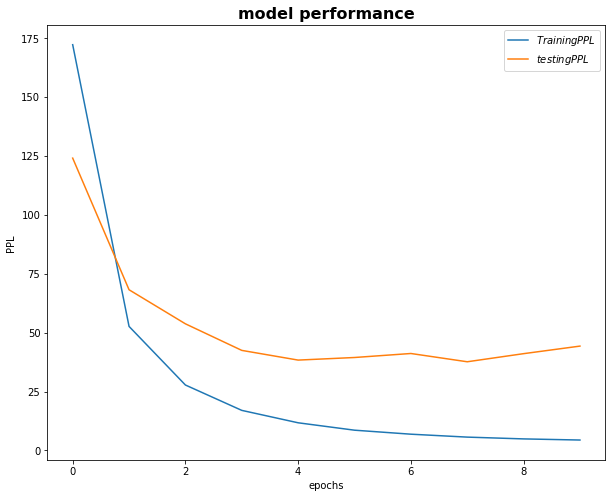

In [ ]:
xpoints = np.arange(len(trainLossList))
ypoints4 = trainAccyList
ypoints6 = valAccyList

plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(xpoints, ypoints4, label = "$ Training PPL $" )
plt.plot(xpoints, ypoints6, label = "$ testing PPL $" )

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("epochs")
plt.ylabel("PPL ")
plt.show()

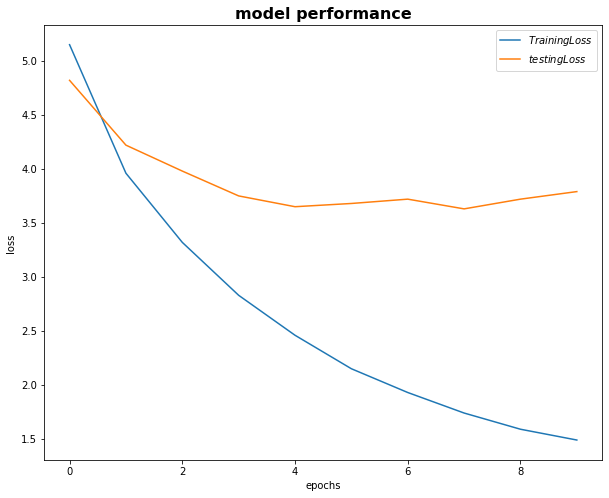

In [ ]:
xpoints = np.arange(len(trainLossList))
ypoints0 = trainLossList
ypoints2 = valLossList


plt.rcParams['figure.figsize'] = [10,8]
plt.plot(xpoints, ypoints0 , label = "$ Training Loss $" )
plt.plot(xpoints, ypoints2, label = "$ testing Loss $" )

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("epochs")
plt.ylabel("loss ")
plt.show()

Finally, we load the parameters from our best validation loss and get our results on the test set.

We get the improved test perplexity whilst almost being twice as fast!

In [ ]:
model.load_state_dict(torch.load('packedmulti30k-model.pt'))

test_loss = evaluate(model, criterion, evaldata = 'test')

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

mmt16_task1_test.tar.gz: 100%|██████████| 43.9k/43.9k [00:00<00:00, 84.6kB/s]


| Test Loss: 3.656 | Test PPL:  38.710 |


## Inference

Now we can use our trained model to generate translations.

**Note:** these translations will be poor compared to examples shown in paper as they use hidden dimension sizes of 1000 and train for 4 days! They have been cherry picked in order to show off what attention should look like on a sufficiently sized model.

Our `translate_sentence` will do the following:
- call text transform for source language on the source sentence
- get the length of the source sentence and convert to a tensor
- feed the source sentence into the encoder
- create the mask for the source sentence
- create a list to hold the output sentence, initialized with an `<bos>` token
- create a tensor to hold the attention values
- while we have not hit a maximum length
  - get the input tensor, which should be either `<bos>` or the last predicted token
  - feed the input, all encoder outputs, hidden state and mask into the decoder
  - store attention values
  - get the predicted next token
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention values over the sequence

### translate sentence

In [ ]:
def translate_sentence(sentence, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        src_tensor = text_transform[SRC_LANGUAGE](sentence)
        src_tensor = src_tensor.unsqueeze(1).to(device)

    #print(src_tensor.shape)
    src_len = torch.LongTensor([src_tensor.shape[0]])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = vocab_transform[TGT_LANGUAGE](['<bos>']) #[trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, src_tensor.shape[0]).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == vocab_transform[ln](['<eos>'])[0] : #trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [vocab_transform[TGT_LANGUAGE].get_itos()[i] for i in trg_indexes]
    #trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

Next, we'll make a function that displays the model's attention over the source sentence for each target token generated.

### display attention

In [ ]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<bos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Now, we'll grab some translations from our dataset and see how well our model did. Note, we're going to cherry pick examples here so it gives us something interesting to look at, but feel free to change the `example_idx` value to look at different examples.

First, we'll get a source and target from our dataset.

Then we'll use our `translate_sentence` function to get our predicted translation and attention. We show this graphically by having the source sentence on the x-axis and the predicted translation on the y-axis. The lighter the square at the intersection between two words, the more attention the model gave to that source word when translating that target word.



In [ ]:
l_iter = Multi30k(split= 'train' , language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))

In [ ]:
src , trg = next(l_iter)

In [ ]:
translation, attention = translate_sentence(src, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['Two', 'young', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']


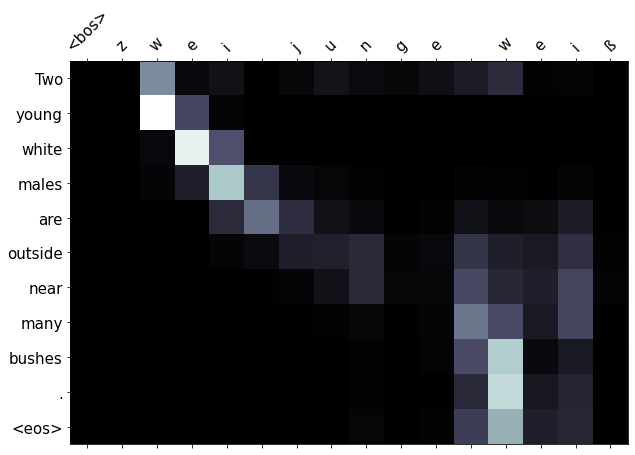

In [ ]:
display_attention(src, translation, attention)

Translations from the training set could simply be memorized by the model. So it's only fair we look at translations from the validation and testing set too.

Starting with the validation set, let's get an example.

In [ ]:
l_iter = Multi30k(split= 'valid' , language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))

In [ ]:
src , trg = next(l_iter)

Then let's generate our translation and view the attention.



predicted trg = ['A', 'group', 'of', 'men', 'loading', 'loading', 'on', 'a', 'truck', '.', '<eos>']


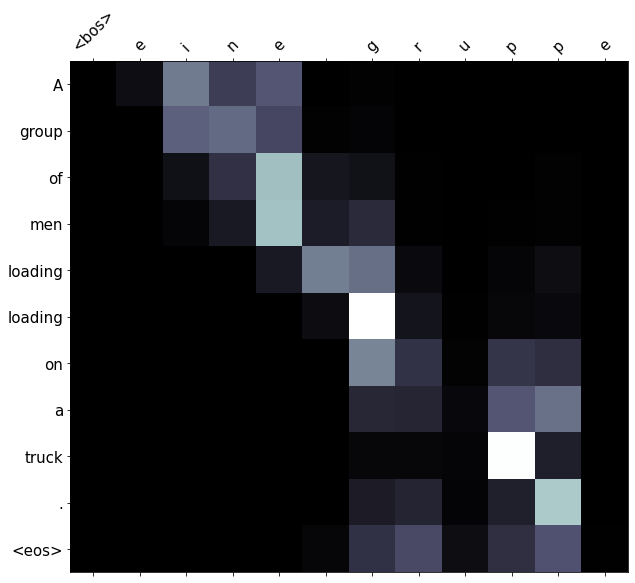

In [ ]:
translation, attention = translate_sentence(src, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

Finally, let's get an example from the test set.

In [ ]:
l_iter = Multi30k(split= 'test' , language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))

In [ ]:
src , trg = next(l_iter)

predicted trg = ['A', 'man', 'wearing', 'an', 'orange', 'hat', 'is', 'holding', 'something', '.', '<eos>']


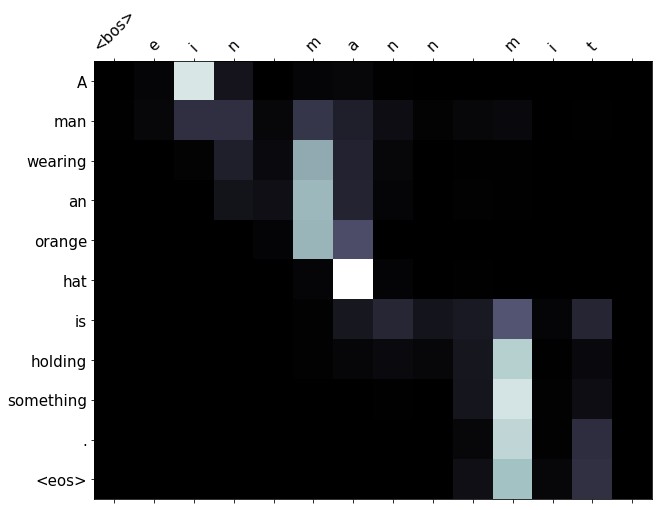

In [ ]:
translation, attention = translate_sentence(src, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

## BLEU

Previously we have only cared about the loss/perplexity of the model. However there metrics that are specifically designed for measuring the quality of a translation - the most popular is *BLEU*. Without going into too much detail, BLEU looks at the overlap in the predicted and actual target sequences in terms of their n-grams. It will give us a number between 0 and 1 for each sequence, where 1 means there is perfect overlap, i.e. a perfect translation, although is usually shown between 0 and 100. BLEU was designed for multiple candidate translations per source sequence, however in this dataset we only have one candidate per source.

We define a `calculate_bleu` function which calculates the BLEU score over a provided TorchText dataset. This function creates a corpus of the actual and predicted translation for each source sentence and then calculates the BLEU score.

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []


    for src, trg in data:
      
        pred_trg, _ = translate_sentence(src, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

### Calculate BLEU score

In [ ]:
#bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)
test_data = Multi30k(split= 'test' , language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
#test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

bleu_score = calculate_bleu(test_data, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 0.00


In the next tutorials we will be moving away from using recurrent neural networks and start looking at other ways to construct sequence-to-sequence models. Specifically, in the next tutorial we will be using convolutional neural networks.

## Bert score

BERTSCORE, a language generation evaluation metric based on pretrained
BERT contextual embeddings (Devlin et al., 2019). BERTSCORE computes the similarity
of two sentences as a sum of cosine similarities between their tokens’ embeddings.

(source :- BERTSCORE: EVALUATING TEXT GENERATION WITH
BERT
Tianyi Zhangyz, Varsha Kishorez, Felix Wuz, Kilian Q. Weinbergeryz, and Yoav Artzizx)

@inproceedings{bert-score,
  title={BERTScore: Evaluating Text Generation with BERT},
  author={Tianyi Zhang* and Varsha Kishore* and Felix Wu* and Kilian Q. Weinberger and Yoav Artzi},
  booktitle={International Conference on Learning Representations},
  year={2020},
  url={https://openreview.net/forum?id=SkeHuCVFDr}
}

In [ ]:
#from torchtext.data.metrics import bleu_score

def getpredictedandactualsentences(data, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []


    for src, trg in data:
      
        pred_trg, _ = translate_sentence(src, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        pred_trg = ' '.join(pred_trg[:-2]) + ' ' + ''.join(pred_trg[-2:])
        #print(pred_trg ,'\n',trg)
        pred_trgs.append(pred_trg)
        trgs.append(trg)
        #print(type(pred_trgs))
    
    return pred_trgs, trgs

### Calculate the precision , recall , F1 for the model

In [ ]:
test_data = Multi30k(split= 'test' , language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))

preds , actls = getpredictedandactualsentences(test_data, model, device, max_len = 50)

P, R, F1 =  score(preds , actls, lang="en", verbose=True)


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.



computing greedy matching.



done in 3.05 seconds, 327.67 sentences/sec


### Plot of Precision score of the model

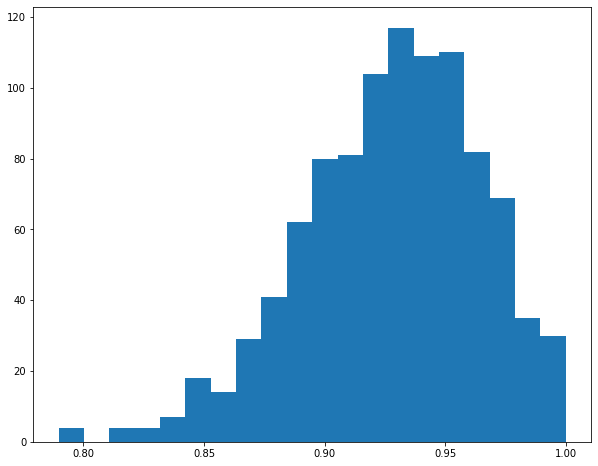

In [ ]:
plt.hist(P, bins=20)
plt.show()

Precision and recall are best understood in the context of binary classification, in the case of language model.The context is still binary in the sense , a cosine similarity gives an idea of closeness between two words - candidate word and reference word.So the idea is , if the model is able to find more and more words with higher cosine similarity, then the candidate and target sentence will be more closer.

A preicision measure alone may not give the right picture, 

* the model is finding lower true positive and lower false positive but higher false positive - precision will be high.

So we must look at the recall , in the above case the recall will be lower. 

Thus we need a joint measure , which is the F1 score , which gives a balanced measure of the model performance.

*  If one of the measure - Precision or Recall is worse , F1 score will reflect that.

*  Only if both measure are better , then F1 score will be better.

Keeping this context we can look at the histogram.

### Precision


The above graph shows the  distribution of cosine similarity between tokens of candidate and reference sentence.

* The model is able to predict words with higher cosine similarity 

  *  higher cosine similarity of (>= 0.9) for most of the tokens

  *  minimum cosine similarity is 0.8

*  A higher precision means fewer false positive



### Plot of Recall of the model

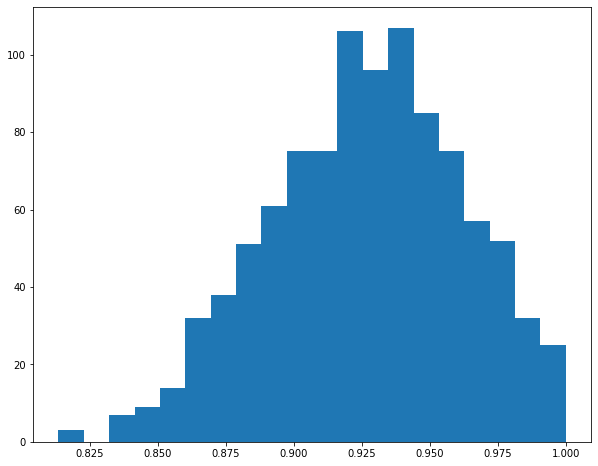

In [ ]:
plt.hist(R, bins=20)
plt.show()

### Recall

The above graph shows the  distribution of cosine similarity between tokens of candidate and reference sentence.

* The model is able to predict words with higher cosine similarity 

  *  higher cosine similarity of (>= 0.9) for most of the tokens

  *  minimum cosine similarity is 0.8

*  A higher recall means fewer false negative 

### Plot of F1 score of the model

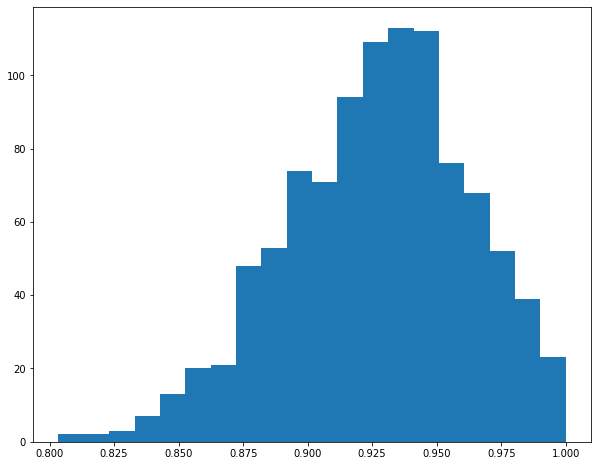

In [ ]:
plt.hist(F1, bins=20)
plt.show()

### F1 Score

As pointed out earlier , only if both measure - Precision and Recall are higher , F1 score will be high.The above plot does reflect that,

*  The distribution is right skewed with higher cosine similarity ( > 0.91 )

*  minimum cosine similarity is 0.82

The model seems to be performing good.

## Display the cosine similarity between the candidate sentence and reference sentence

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


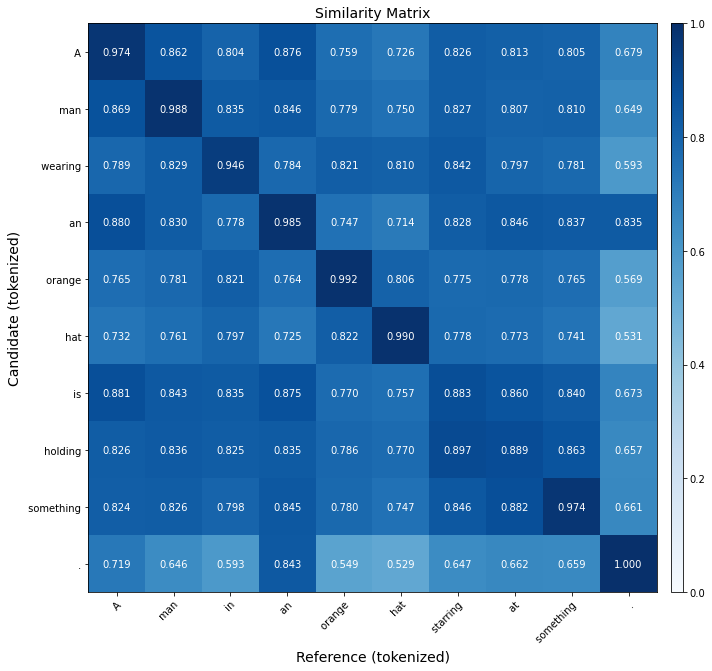

In [ ]:

from bert_score import plot_example

pred = preds[0]
actl =  actls[0]
plot_example(pred, actl, lang="en")